In [1]:
import os
import sys
import cv2
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
from keras.applications import *
from force_utils import DataProcessing, evaluate_model

Using TensorFlow backend.


In [2]:
video_file = 'dataset/video.mp4'
cap = cv2.VideoCapture(video_file)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [3]:
base_input_shape = (299, 299, 3)
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=base_input_shape))
base_model = Model(inputs=base_model.input, outputs=base_model.output)

In [4]:
top_input_shape = base_model.output_shape[1:]
top_input_tensor = Input(shape=top_input_shape)
x = Flatten(input_shape=top_input_shape)(top_input_tensor)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(6)(x)
top_model = Model(inputs=top_input_tensor, outputs=prediction)
top_model.load_weights('dataset/weights/six_04.h5')

In [15]:
frames, preds = [], []
cap.set(1, 62000)
while(cap.isOpened()):
    flag, frame = cap.read()
    frame_num = cap.get(1)
    if flag == False or frame_num > frame_count:
        break
    img = Image.fromarray(np.uint8(frame[:,:,:])).resize((base_input_shape[0], base_input_shape[1]))
    img = np.asarray(img)
    img = img[np.newaxis, :, :, :]
    frames.append(frame_num)
    base_output = base_model.predict(img / 255.0)
    pred = top_model.predict(base_output)
    preds.append(pred)
    sys.stdout.write("\r%d%s%d" % (frame_num, ' / ', frame_count))
    sys.stdout.flush()

69821 / 69821

In [16]:
frames = np.array(frames)
preds = np.array(preds)
print(frames.shape, preds.shape)

(7821,) (7821, 1, 6)


In [19]:
preds[0][0]

array([ 0.1152904 ,  0.12168586,  0.12771408,  0.02330747,  0.28504318,
       -0.12234802], dtype=float32)

In [20]:
fx, fy, fz = preds[:, 0, 3], preds[:, 0, 4], preds[:, 0, 5]
fx, fy, fz = np.absolute(fx), np.absolute(fy), np.absolute(fz)
f_preds = np.round(np.sqrt(np.power(fx, 2) + np.power(fy, 2) + np.power(fz, 2)), 3)

In [21]:
f_preds.shape

(7821,)

In [22]:
dataset = DataProcessing('dataset/video.mp4', 'dataset/forceinfo.csv')

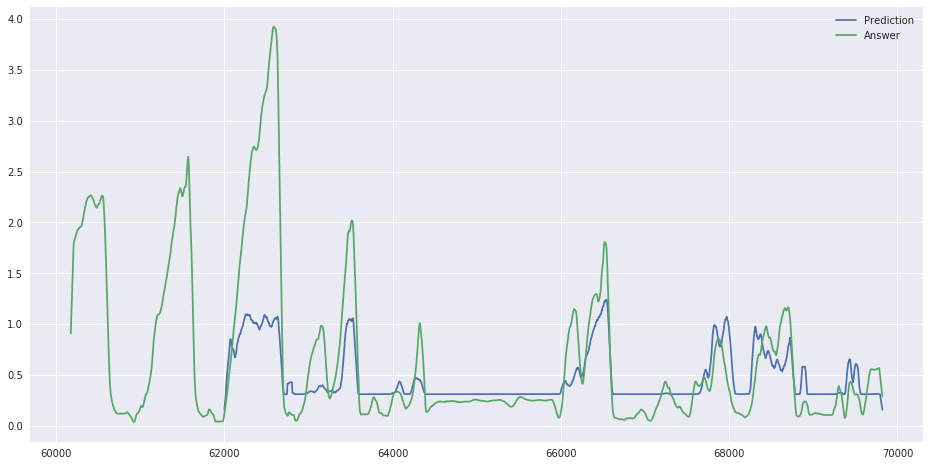

In [23]:
# convolve
average = 59
conv_preds = np.convolve(f_preds, np.ones(average)/float(average), 'same')
answer_keys = list(dataset.f_dict.keys())
answer_keys = answer_keys[-len(preds):]
answer_vals = list(dataset.f_dict.values())
answer_vals = answer_vals[-len(preds):]
conv_answer_vals = np.convolve(answer_vals, np.ones(average)/float(average), 'same')

import seaborn as sns
bins = 80
norm_hist = True
sns.set()
plt.figure(figsize=(16, 8))
plt.plot(frames, conv_preds, label='Prediction')
plt.plot(answer_keys, conv_answer_vals, label='Answer')
plt.legend()